In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

In [3]:
lal.G_SI, lal.C_SI, 1.0e6*lal.PC_SI, lal.MSUN_SI

(6.67384e-11, 299792458.0, 3.085677581491367e+22, 1.9885469549614615e+30)

In [4]:
# Use the exact same units as LAL
G_SI = 6.67384e-11
C_SI = 299792458.0
MPC_SI = 3.085677581491367e+22
MSUN_SI = 1.9885469549614615e+30

In [5]:
# Versions of HDF5 earlier than 1.8.13 seem to give trouble
import h5py
print h5py.version.info

Summary of the h5py configuration
---------------------------------

h5py    2.5.0
HDF5    1.8.14
Python  2.7.10 (default, Jul 14 2015, 19:46:27) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.39)]
sys.platform    darwin
sys.maxsize     9223372036854775807
numpy   1.9.2



In [36]:
sys.path.insert(0, '../src')

import timedomainwaveform as tdwave
import timedomainrom as tdrom
import eobtrainingset as eob
import greedy
import empiricalinterpolation as eim
import diagnostics as diagnostics
import chebyshev as cheb
import timeseriesutils as tsutils

import imp
imp.reload(tdwave)
imp.reload(tdrom)
imp.reload(eob)
imp.reload(greedy)
imp.reload(eim)
imp.reload(diagnostics)
imp.reload(cheb)
imp.reload(tsutils)

<module 'timeseriesutils' from '../src/timeseriesutils.py'>

# Load ROM

In [7]:
memb_size=2**26-1
Bamp_filename = '../data/Bamp_%d.hdf5'
Bphase_filename = '../data/Bphase_%d.hdf5'
ampcoeff_filename = '../data/amp_coeffs.hdf5'
phasecoeff_filename = '../data/phase_coeffs.hdf5'
rom = tdrom.load_reduced_order_model_time_domain_waveform(Bamp_filename, Bphase_filename, memb_size,
                                                  ampcoeff_filename, phasecoeff_filename)

In [8]:
def reduced_order_model_time_series(rom, **kwargs):
    """Convert to pycbc TimeSeries.
    """
    tstart, delta_t, hp, hc = rom.evaluate_physical_units(**kwargs)
    hplus = pycbc.types.TimeSeries(hp, epoch=tstart, delta_t=delta_t)
    hcross = pycbc.types.TimeSeries(hc, epoch=tstart, delta_t=delta_t)
    return hplus, hcross

# Test ROM with physical units

In [91]:
#distance, inclination, f_lower, delta_t = 100.0, 1.1*np.pi/2.0, 100.0, 1.0/2**14
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 2.0, 1.0, 5000.0, 50.0
hp1, hc1 = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

mass1, mass2, lambda1, lambda2 = 2.0, 1.0, 50.0, 5000.0
hp2, hc2 = reduced_order_model_time_series(rom, mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                                        delta_t=delta_t, f_lower=f_lower, f_ref=None, 
                                        distance=distance, inclination=inclination, coa_phase=None)

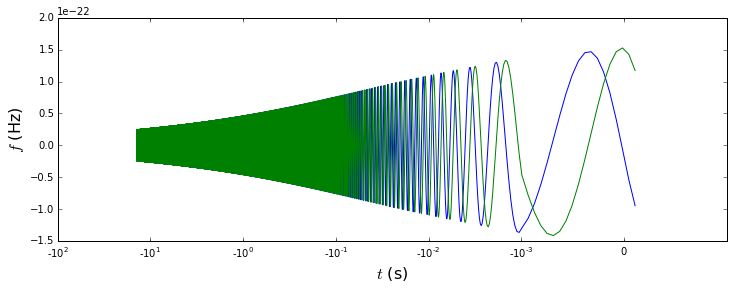

In [92]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(111)
axes.plot(hp1.sample_times, hp1.numpy())
axes.plot(hc1.sample_times, hc1.numpy())
axes.set_xscale('symlog', linthreshx=0.001)
axes.set_xlabel(r'$t$ (s)', fontsize=16)
axes.set_ylabel(r'$f$ (Hz)', fontsize=16)

# Compare ROM to TaylorT4

In [93]:
#distance, inclination, f_lower, delta_t = 100.0, 1.1*np.pi/2.0, 100.0, 1.0/2**14
distance, inclination, f_lower, delta_t = 100.0, 0.0, 50.0, 1.0/2**14

mass1, mass2, lambda1, lambda2 = 2.0, 1.0, 5000.0, 50.0
hp1T4, hc1T4 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
                        phase_order=7, tidal_order=12, amplitude_order=6)

mass1, mass2, lambda1, lambda2 = 2.0, 1.0, 50.0, 5000.0
hp2T4, hc2T4 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
                        phase_order=7, tidal_order=12, amplitude_order=6)

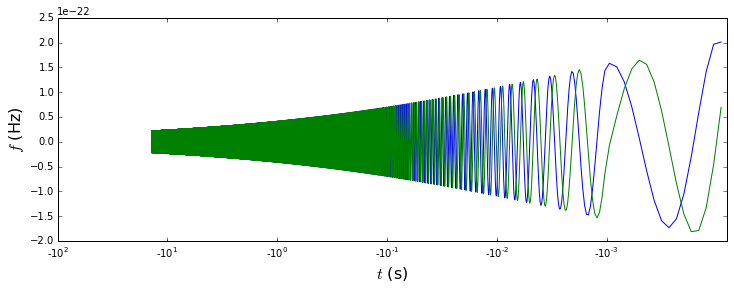

In [94]:
fig = plt.figure(figsize=(12, 4))
axes = fig.add_subplot(111)
axes.plot(hp1T4.sample_times, hp1T4.numpy())
axes.plot(hc1T4.sample_times, hc1T4.numpy())
axes.set_xscale('symlog', linthreshx=0.001)
axes.set_xlabel(r'$t$ (s)', fontsize=16)
axes.set_ylabel(r'$f$ (Hz)', fontsize=16)

In [95]:
def zero_start_time_phase(hp, hc):
    amp, phase = tsutils.amp_phase_from_polarizations(hp, hc, remove_start_phase=True)
    hcomplex = tsutils.complex_from_amp_phase(amp, phase)
    hcomplex.start_time -= hcomplex.start_time
    return hcomplex

In [96]:
h1 = zero_start_time_phase(hp1, hc1)
h2 = zero_start_time_phase(hp2, hc2)
h1T4 = zero_start_time_phase(hp1T4, hc1T4)
h2T4 = zero_start_time_phase(hp2T4, hc2T4)

In [97]:
print h1[0], h2[0], h1T4[0], h2T4[0]
print h1.start_time, h2.start_time, h1T4.start_time, h2T4.start_time
print h1.sample_times[-1], h2.sample_times[-1], h1T4.sample_times[-1], h2T4.sample_times[-1]

(2.45105262814e-23+0j) (2.45103640674e-23+0j) (2.18361606773e-23+0j) (2.18361606773e-23+0j)
0.000000000 0.000000000 0.000000000 0.000000000
13.9780273438 14.0040283203 13.9934692383 14.0062255859


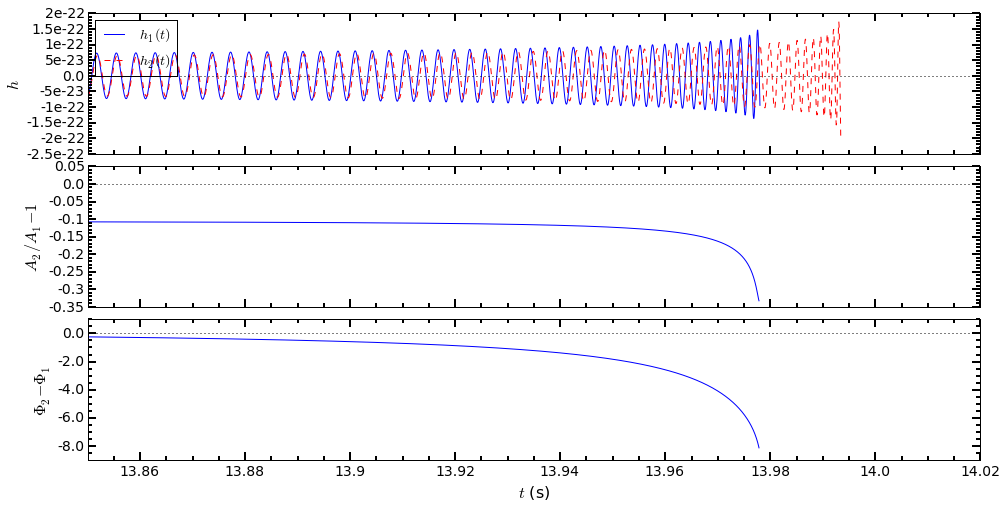

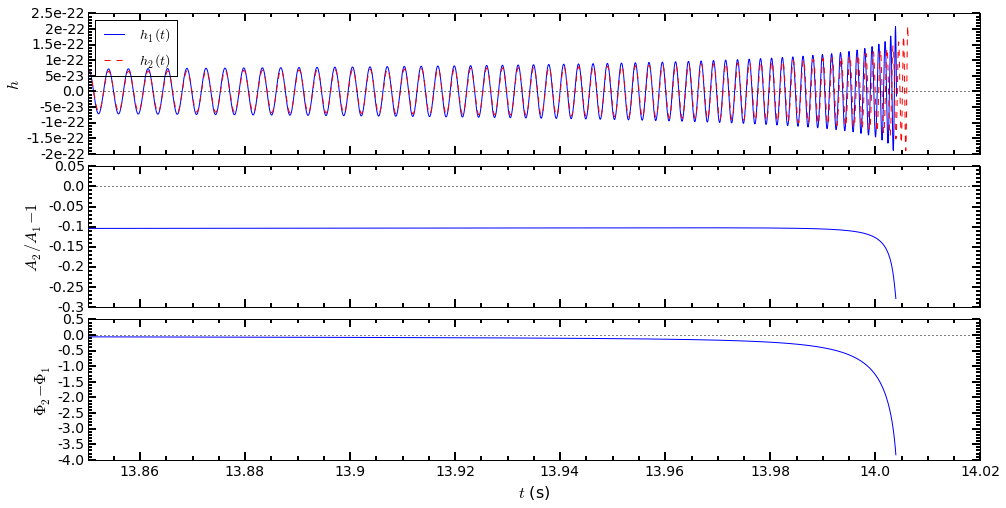

In [104]:
fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h1, h1T4, mag=None, xlim=[13.85, 14.02],
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_2/A_1 - 1$',
                              ylabel_phase=r'$\Phi_2 - \Phi_1$',
                              labels=[r'$h_1(t)$', r'$h_2(t)$'])

fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h2, h2T4, mag=None, xlim=[13.85, 14.02],
                              remove_start_phase=True,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_2/A_1 - 1$',
                              ylabel_phase=r'$\Phi_2 - \Phi_1$',
                              labels=[r'$h_1(t)$', r'$h_2(t)$'])

# Compare phase difference due to tidal interactions for ROM and TaylorT4

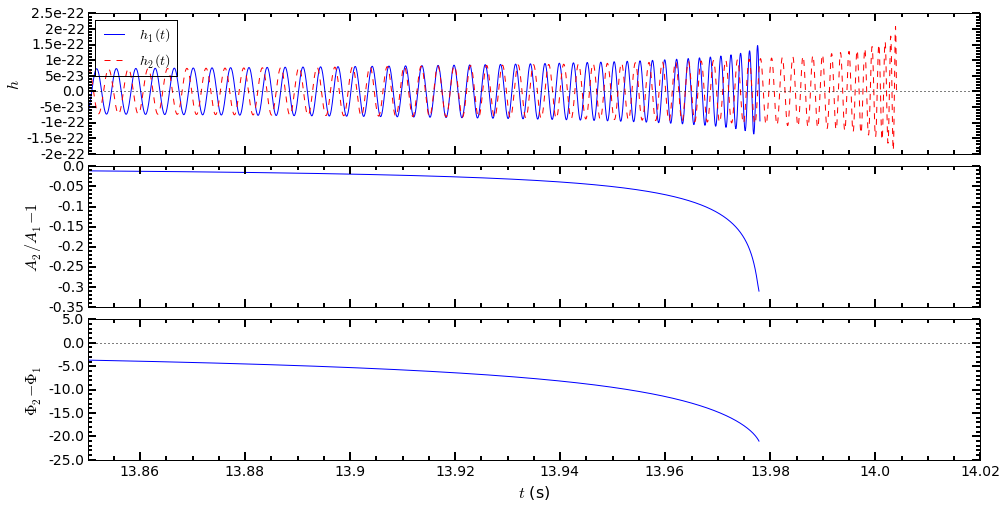

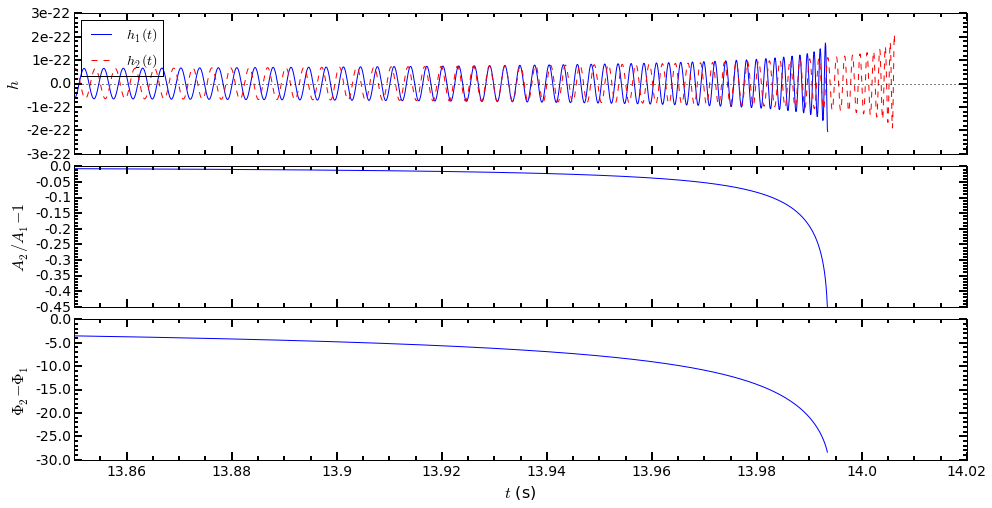

In [105]:
fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h1, h2, mag=None, xlim=[13.85, 14.02],
                              remove_start_phase=False,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_2/A_1 - 1$',
                              ylabel_phase=r'$\Phi_2 - \Phi_1$',
                              labels=[r'$h_1(t)$', r'$h_2(t)$'])

fig = plt.figure(figsize=(16, 8))
tsutils.compare_two_waveforms(fig, h1T4, h2T4, mag=None, xlim=[13.85, 14.02],
                              remove_start_phase=False,
                              xlabel=r'$t$ (s)', ylabel_wave=r'$h$',
                              ylabel_amp=r'$A_2/A_1 - 1$',
                              ylabel_phase=r'$\Phi_2 - \Phi_1$',
                              labels=[r'$h_1(t)$', r'$h_2(t)$'])

In [114]:
from scipy.stats import norm

(0.017864420562816563, 1.698267406702314e-07)

In [115]:
1-norm.cdf(2.1), 1-norm.cdf(5.1)

(0.017864420562816563, 1.698267406702314e-07)

In [116]:
norm.sf(2.1), norm.sf(5.1)

(0.017864420562816542, 1.6982674071475966e-07)

In [113]:
norm.isf(2.0e-2, loc=0, scale=1), norm.isf(2.0e-7, loc=0, scale=1)

(2.053748910631823, 5.0689577497177911)